In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import ConfusionMatrixDisplay
from torchvision import datasets, transforms

In [3]:
train = datasets.MNIST('../data', train=True, transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST('../data', train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [4]:
def plot(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

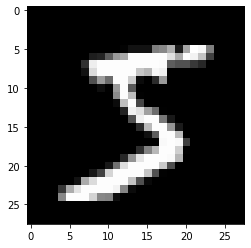

In [5]:
plot(train.data[0])

In [9]:
x = (train.data.float() / 255).reshape(train.data.size(0), -1)
y = train.targets
x.shape, y.shape

(torch.Size([60000, 784]), torch.Size([60000]))

In [10]:
input_size = x.size(-1)
output_size = int(max(y)) + 1

In [12]:
ratios = [0.8, 0.2]
train_cnt = int(x.shape[0] * ratios[0])
valid_cnt = x.shape[0] - train_cnt
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

In [13]:
indices = torch.randperm(x.shape[0])
x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)
x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))
x += [(test.data.float() / 255).reshape(test_cnt, -1)]
y += [test.targets]
for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [65]:
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, output_size),
    nn.Softmax(dim=-1)
)
opt = optim.Adam(model.parameters())
crit = nn.CrossEntropyLoss()

In [66]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [67]:
model = model.to(device)
x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]
for x_i, y_i in zip(x, y):
    print(x_i.shape, y_i.shape)

torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [68]:
n_epochs = 1000
batch_size = 256
print_interval = 10

In [69]:
lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf
early_stop = 30

In [70]:
train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(x[0].shape[0]).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += float(loss)
    
    train_loss = train_loss / len(x_)

    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())

            valid_loss += float(loss)

            y_hat += [y_hat_i]

    valid_loss = valid_loss / len(x_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if valid_loss < lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and early_stop + lowest_epoch < i + 1:
            print(f'There is no improvement during last {early_stop} epochs.')
            break

    if (i + 1) % print_interval == 0:
        print(f'Epoch {i + 1}: train loss={train_loss:.6f}, valid loss={valid_loss:.6f}, lowest loss={lowest_loss:.6f}')

print(f'The best validation loss from epoch {lowest_epoch + 1}: {lowest_loss:.6f}')

model.load_state_dict(best_model)

Epoch 10: train loss=1.492951, valid loss=1.502835, lowest loss=1.501885
Epoch 20: train loss=1.495824, valid loss=1.502696, lowest loss=1.496253
Epoch 30: train loss=1.497950, valid loss=1.518923, lowest loss=1.496253
Epoch 40: train loss=1.501500, valid loss=1.510755, lowest loss=1.496253
There is no improvement during last 30 epochs.
The best validation loss from epoch 15: 1.496253


<All keys matched successfully>

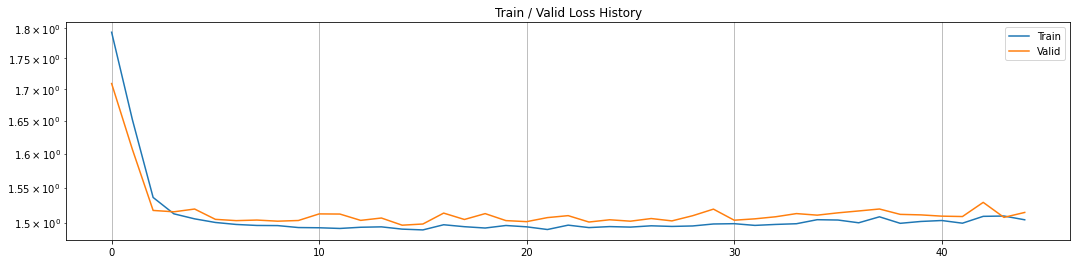

In [71]:
plot_from = 0

fig, ax = plt.subplots(1, 1, figsize=(18, 4))
plt.title('Train / Valid Loss History')
ax.plot(range(plot_from, len(train_history)), train_history[plot_from:],
         range(plot_from, len(valid_history)), valid_history[plot_from:])
plt.grid(True)
plt.yscale('log')
plt.legend(['Train', 'Valid'])
plt.show()

In [72]:
with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    test_loss = 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += float(loss)
        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.concat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

print(f'Train loss: {sorted_history[0][0]:.4f}')
print(f'Valid loss: {sorted_history[0][1]:.4f}')
print(f'Test loss: {test_loss:.4f}')

Train loss: 1.4907
Valid loss: 1.4963
Test loss: 1.4928


In [73]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = y[-1].shape[0]
print(f'Test Accuracy: {correct_cnt / total_cnt:.2%}')

Test Accuracy: 96.74%


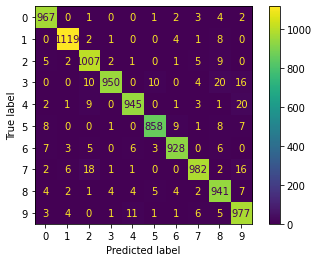

In [74]:
ConfusionMatrixDisplay.from_predictions(y[-1].squeeze(), torch.argmax(y_hat, dim=-1))

In [91]:
data_df = (pd.DataFrame(torch.concat([y[-1].reshape(-1, 1),
                           torch.argmax(y_hat, dim=-1).reshape(-1, 1),
                           torch.max(y_hat, dim=-1).values.reshape(-1, 1)
                           ], dim=1).detach().numpy(), columns=['y', 'y_hat', 'prob'])
)
data_df

,y,y_hat,prob
0,7.0,7.0,1.0
1,2.0,2.0,1.0
2,1.0,1.0,1.0
3,0.0,0.0,1.0
4,4.0,4.0,1.0
...,...,...,...
9995,2.0,2.0,1.0
9996,3.0,3.0,1.0
9997,4.0,4.0,1.0
9998,5.0,5.0,1.0


In [99]:
data_df2 = (data_df
 .query("prob > 0.95")
)
data_df2

,y,y_hat,prob
0,7.0,7.0,1.0
1,2.0,2.0,1.0
2,1.0,1.0,1.0
3,0.0,0.0,1.0
4,4.0,4.0,1.0
...,...,...,...
9995,2.0,2.0,1.0
9996,3.0,3.0,1.0
9997,4.0,4.0,1.0
9998,5.0,5.0,1.0


c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

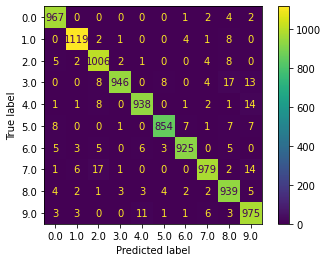

In [100]:
ConfusionMatrixDisplay.from_predictions(data_df2['y'], data_df2['y_hat'])

In [101]:
correct_cnt2 = (data_df2['y'] == data_df2['y_hat']).sum()
total_cnt2 = data_df2.shape[0]
print(f'Test Accuracy: {correct_cnt2 / total_cnt2:.2%}')

Test Accuracy: 97.20%
